# spaCyチュートリアル
#### 03 spaCy上級

In [1]:
%matplotlib inline
import spacy
from spacy.gold import GoldParse
from spacy.scorer import Scorer
from spacy.util import decaying, minibatch, compounding
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot.plotters as skplt

## GPUの使用  
GPU版spaCyは対応するCUDAバージョンを指定してインストールします。GPU版spaCyはNumPyの代わりにGPUで高速計算可能な[CuPy](http://learningsys.org/nips17/assets/papers/paper_16.pdf)を使用しています

In [2]:
# !pip install -U spacy[cuda100]

In [2]:
# GPUが有効か確認する
spacy.prefer_gpu()

True

In [3]:
# 最初のGPUカードを使用する
spacy.util.use_gpu(0)

<CUDA Device 0>

## モデル学習

SpaCyのモデルを一から学習したり、学習済みモデルを再学習することが可能です。文書分類や固有表現抽出には特に有効です。  

1. ランダムな重みでモデルを初期化する。`nlp.begin_training`
2. 現在の重みで学習データの内複数のデータを予測する。 `nlp.update`
3. 予測と正解ラベルを比べる。
4. 精度を向上させるように重みの更新方法を計算する（勾配）。
5. 重みを若干更新する。
6. 2から5を繰り返す。  

ここでは実際に固有表現抽出モデルを学習します。  

![model_training](img/model_training.png)  

使うデータは[Hironsanの日本語用NERデータ](https://github.com/Hironsan/IOB2Corpus/blob/master/hironsan.txt)です。

In [28]:
# !wget https://github.com/Hironsan/IOB2Corpus/raw/master/hironsan.txt -P data

### 日本語用NERデータをspaCy用に変換する

In [42]:
def spaCy用nerデータ変換(ファイル名:str=None):
    try:
        ファイル=open(ファイル名, 'r')
        全データリスト = []
        文章 = ''
        開始 = 0
        データタプル = ()
        ラベル辞書 = {}
        固有表現リスト = []

        for 行数, ライン in enumerate(ファイル, 1):
            if ライン == '\n':
                全データリスト.append((文章, {"entities": 固有表現リスト}))
                文章 = ''
                開始 = 0
                データタプル = ()
                ラベル辞書 = {}
                固有表現リスト = []

            if ライン != '\n':
                ラインパース = ライン.split('\t')
                単語 = ラインパース[0]
                固有表現 = ラインパース[len(ラインパース) - 1]
                文章 += 単語.strip() + " "
                固有表現 = 固有表現.strip()

                if 固有表現 != 'O':
                    固有表現 = 固有表現.split("-")[1]
                    開始位置 = 開始
                    終了位置 = 開始 + len(単語)
                    固有表現リスト.append((開始位置, 終了位置, 固有表現))

                開始+=len(単語)+1
    except:
        print("しんでしまうとはなさけない")
        return None
    return 全データリスト

In [43]:
全データ = spaCy用nerデータ変換('data/hironsan.txt')

In [45]:
len(all_data)

500

In [46]:
# 学習データと評価データに分ける
学習データ = 全データ[0:400]
評価データ = 全データ[400:]

In [58]:
len(学習データ), len(評価データ)

(400, 100)

### 固有表現抽出を学習する

In [59]:
random.seed(0)

# "ja"だとMeCabが必要だと怒られるので"en"で初期化。既に分かち書きされているので問題ないはず。
nlp = spacy.blank("en")
ner = nlp.create_pipe("ner")
nlp.add_pipe(ner)

# BILUO方式に変換する
for _, アノテーション in 学習データ:
    for 固有表現 in アノテーション.get("entities"):
        ner.add_label(固有表現[2])

# Adam (1e-3, beta1=0.9, beta2-0.999, L2=1e-6)
最適化法 = nlp.begin_training(device=0)
    
一意固有表現 = list(ner.move_names)

# 不要なパイプラインを無効にするためコンポーネント名を所得する
不要パイプ = [パイプ for パイプ in nlp.pipe_names if パイプ != "ner"]

In [60]:
一意固有表現

['O',
 'B-DAT',
 'I-DAT',
 'L-DAT',
 'U-DAT',
 'B-LOC',
 'I-LOC',
 'L-LOC',
 'U-LOC',
 'B-ORG',
 'I-ORG',
 'L-ORG',
 'U-ORG',
 'B-ART',
 'I-ART',
 'L-ART',
 'U-ART',
 'B-PSN',
 'I-PSN',
 'L-PSN',
 'U-PSN',
 'B-TIM',
 'I-TIM',
 'L-TIM',
 'U-TIM',
 'B-PNT',
 'I-PNT',
 'L-PNT',
 'U-PNT',
 'B-MNY',
 'I-MNY',
 'L-MNY',
 'U-MNY']

In [61]:
# 評価関数
def 固有表現評価(nlp:spacy.lang.en.English=None, 評価データ:list=None):
    scorer = Scorer()
    
    for テキスト, アノテーション in 評価データ:
        文章 = nlp(テキスト)
        ラベル = GoldParse(文章, entities=アノテーション['entities'])
        scorer.score(文章, ラベル)
        
    return scorer.scores

In [65]:
def 固有表現学習(エポック数:int=5, 学習データ:list=None, 評価データ:list=None, 最大バッチ数:int=32):
    with nlp.disable_pipes(*不要パイプ):  # 固有表現抽出だけ学習
        学習状況 = []
        ドロップアウト = decaying(0.5, 0.2, 0.3) # ドロップアウトを0.5から0.2に徐々に減少させる
        バッチ数 = compounding(4.0, 最大バッチ数, 1.001)
        
        for エポック in range(エポック数):
            random.shuffle(学習データ)
            全バッチ = minibatch(学習データ, size=バッチ数)
            損失 = {}

            for バッチ in 全バッチ:
                テキスト, ラベル = zip(*バッチ)
                nlp.update(
                    テキスト, 
                    ラベル, 
                    drop = next(ドロップアウト),
                    sgd = 最適化法,
                    losses=損失)
            
            print(f"エポック: {エポック+1}")
            print(f"損失: {損失}")
            評価スコア = 固有表現評価(nlp, 評価データ)
            print(評価スコア)

            学習状況.append(損失)
            学習状況.append(評価スコア)

In [66]:
固有表現学習(エポック数=20, 学習データ=学習データ, 評価データ=評価データ, 最大バッチ数=128)

エポック: 1
損失: {'ner': 3599.727813688958}
{'uas': 0.0, 'las': 0.0, 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}}, 'ents_p': 68.50828729281768, 'ents_r': 25.101214574898783, 'ents_f': 36.74074074074074, 'ents_per_type': {'DAT': {'p': 68.88888888888889, 'r': 86.91588785046729, 'f': 76.85950413223141}, 'ART': {'p': 0.0, 'r': 0.0, 'f': 0.0}, 'ORG': {'p': 0.0, 'r': 0.0, 'f': 0.0}, 'LOC': {'p': 67.3913043478261, 'r': 20.26143790849673, 'f': 31.155778894472363}, 'MNY': {'p': 0.0, 'r': 0.0, 'f': 0.0}, 'PNT': {'p': 0.0, 'r': 0.0, 'f': 0.0}, 'PSN': {'p': 0.0, 'r': 0.0, 'f': 0.0}, 'TIM': {'p': 0.0, 'r': 0.0, 'f': 0.0}}, 'tags_acc': 0.0, 'token_acc': 100.0, 'textcat_score': 0.0, 'textcats_per_cat': {}}
エポック: 2
損失: {'ner': 1928.4850302033924}
{'uas': 0.0, 'las': 0.0, 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}}, 'ents_p': 68.70503597122301, 'ents_r': 38.663967611336034, 'ents_f': 49.48186528497409, 'ents_per_type': {'ORG': {'p': 11.76470588235294, 'r': 2.3529411764705883, 'f': 3.9215686

In [ ]:
!mkdir -p model

In [67]:
# モデルを保存する
nlp.to_disk('model/ja_ner_v1')

In [69]:
# 重みを平均する (https://www.aclweb.org/anthology/P04-1015/)
with nlp.use_params(最適化法.averages):
    nlp.to_disk('model/ja_ner_v1_wa')

In [70]:
nlp_wa = nlp.from_disk('model/ja_ner_v1_wa')

In [75]:
# 評価
固有表現評価(nlp, 評価データ)

{'uas': 0.0,
 'las': 0.0,
 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}},
 'ents_p': 71.2082262210797,
 'ents_r': 56.07287449392713,
 'ents_f': 62.74065685164214,
 'ents_per_type': {'ORG': {'p': 50.98039215686274,
   'r': 30.58823529411765,
   'f': 38.23529411764706},
  'DAT': {'p': 98.05825242718447,
   'r': 94.39252336448598,
   'f': 96.19047619047619},
  'LOC': {'p': 71.31147540983606,
   'r': 56.86274509803921,
   'f': 63.272727272727266},
  'ART': {'p': 66.66666666666666,
   'r': 16.666666666666664,
   'f': 26.666666666666668},
  'PSN': {'p': 5.0, 'r': 15.384615384615385, 'f': 7.547169811320756},
  'TIM': {'p': 90.56603773584906, 'r': 96.0, 'f': 93.20388349514563},
  'MNY': {'p': 0.0, 'r': 0.0, 'f': 0.0},
  'PNT': {'p': 100.0, 'r': 25.0, 'f': 40.0}},
 'tags_acc': 0.0,
 'token_acc': 100.0,
 'textcat_score': 0.0,
 'textcats_per_cat': {}}

In [76]:
# 評価
固有表現評価(nlp_wa, 評価データ)

{'uas': 0.0,
 'las': 0.0,
 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}},
 'ents_p': 71.2082262210797,
 'ents_r': 56.07287449392713,
 'ents_f': 62.74065685164214,
 'ents_per_type': {'ORG': {'p': 50.98039215686274,
   'r': 30.58823529411765,
   'f': 38.23529411764706},
  'DAT': {'p': 98.05825242718447,
   'r': 94.39252336448598,
   'f': 96.19047619047619},
  'LOC': {'p': 71.31147540983606,
   'r': 56.86274509803921,
   'f': 63.272727272727266},
  'ART': {'p': 66.66666666666666,
   'r': 16.666666666666664,
   'f': 26.666666666666668},
  'PSN': {'p': 5.0, 'r': 15.384615384615385, 'f': 7.547169811320756},
  'TIM': {'p': 90.56603773584906, 'r': 96.0, 'f': 93.20388349514563},
  'MNY': {'p': 0.0, 'r': 0.0, 'f': 0.0},
  'PNT': {'p': 100.0, 'r': 25.0, 'f': 40.0}},
 'tags_acc': 0.0,
 'token_acc': 100.0,
 'textcat_score': 0.0,
 'textcats_per_cat': {}}

### 抜き打ち検査

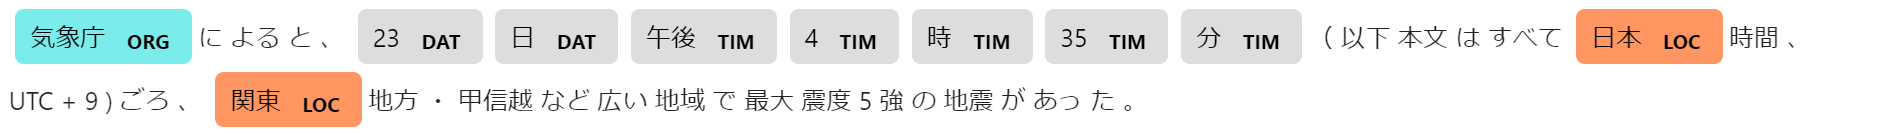

In [77]:
文章 = [nlp(テキスト) for テキスト, アノテーション in [評価データ[random.randint(0, len(評価データ))]]][0]
spacy.displacy.render(文章, style='ent')

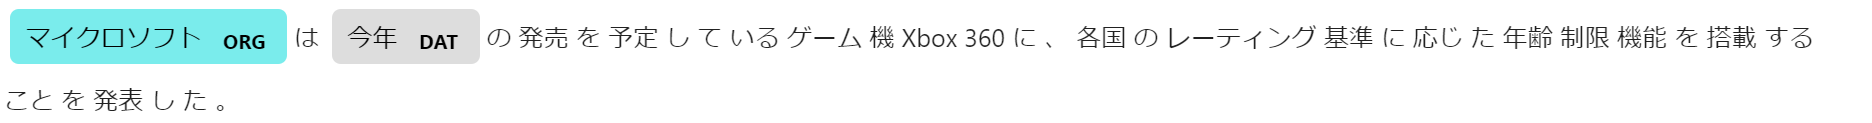

In [78]:
文章 = [nlp(テキスト) for テキスト, アノテーション in [評価データ[random.randint(0, len(評価データ))]]][0]
spacy.displacy.render(文章, style='ent')

## トランスフォーマーモデルの使用  
`spacy-transformers`パッケージはspaCyのパイプラインにHugging Faceの[transformersパッケージ](https://github.com/huggingface/transformers) に含まれる最先端のトランスフォーマーアーキテキチャに基づくモデル（[BERT](https://arxiv.org/abs/1810.04805)、[GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)、[XLNet](https://arxiv.org/abs/1906.08237)など）の便利な機能を追加します。こういった学習済みモデルは大量の文章を言語モデルで学習させています。  

このチュートリアルでは日本語BERTを使っていきます。

In [2]:
# !pip install spacy-transformers

In [2]:
# # 日本語BERTモデルをダウンロード、解凍、ファイル名を変更（ファイル名がbertで始まらないとspaCyでエラーが発生する）
# !wget https://www.nlp.ecei.tohoku.ac.jp/~m-suzuki/bert-japanese/BERT-base_mecab-ipadic-bpe-32k_whole-word-mask.tar.xz -P model
# !tar xf model/BERT-base_mecab-ipadic-bpe-32k_whole-word-mask.tar.xz -C model
# !mv model/BERT-base_mecab-ipadic-bpe-32k_whole-word-mask model/bert_ja

In [ ]:
# # MeCabをインストールする（トークン化に必要）
# !apt-get install -y mecab mecab-ipadic-utf8 libmecab-dev
# !pip install mecab-python3

In [2]:
import torch
from spacy_transformers import TransformersLanguage, TransformersWordPiecer, TransformersTok2Vec

# モデルを読み込む
name = "bert_ja"
path = "model/bert_ja"

nlp = TransformersLanguage(trf_name=name, meta={"lang": "ja"})
nlp.add_pipe(nlp.create_pipe("sentencizer"))
nlp.add_pipe(TransformersWordPiecer.from_pretrained(nlp.vocab, path))
nlp.add_pipe(TransformersTok2Vec.from_pretrained(nlp.vocab, path))

In [3]:
# CUDAテンソルを使用する
if spacy.prefer_gpu():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

In [4]:
# パイプラインが通常のspaCyと違う
print(nlp.pipe_names)

['sentencizer', 'trf_wordpiecer', 'trf_tok2vec']


### 類似度の確認  
通常の単語ベクトルと違いBERTのような言語モデルベースの単語ベクトルは文脈を考慮したものを出力します。この機能はspaCyの既存のsimilarityメソッドに追加されます。  

同じ様に自分でTensorFlow等の他の機械学習フレームワークで学習したモデル(例えば自然言語推論(NLI))をsimilarityメソッドに追加する事も可能です。

In [5]:
リンゴ1 = nlp("アップル株最高値、5G iPhone発売")
リンゴ2 = nlp("アップルパイとは、砂糖煮にしたリンゴを詰めてオーブンで焼いたパイのこと。")
リンゴ3 = nlp("アップルとさつまいもケーキの簡単おいしいレシピ")
print(リンゴ1[0].similarity(リンゴ2[0]))  # 会社名と食べ物
print(リンゴ2[0].similarity(リンゴ3[0]))  # 両方とも食べ物

0.8145274
0.8711613


In [6]:
# 文章の類似度
リンゴ1.similarity(リンゴ3)

array(0.81524175, dtype=float32)

In [7]:
# 文章の類似度
リンゴ2.similarity(リンゴ3)

array(0.8737486, dtype=float32)

In [8]:
# (wordpiecesトークン数、次元数)
# [CLS]の埋め込みはtrf_last_hidden_state[0]です
リンゴ1._.trf_last_hidden_state.shape, リンゴ2._.trf_last_hidden_state.shape, リンゴ3._.trf_last_hidden_state.shape,

((16, 768), (28, 768), (18, 768))

In [9]:
# wordpiecesをプリントする
print(リンゴ1._.trf_word_pieces_)

['[CLS]', 'アッ', '##フル', '株', '最', '高', '値', '、', '5', '##g', 'i', '##ph', '##one', '発', '売', '[SEP]']


### 転移学習  
学習済みトランスフォーマーモデルは転移学習にも利用できます。コンピュータービジョン系の学習済みモデル(ResNetやInception等)の転移学習と同様、自分独自のデータセットとラベルに対してモデル学習ができます。`nlp.update`で学習済みモデルの重みも更新するファインチューニングも可能です。  

転移学習はspaCyの決められたパイプラインにしか対応していません。例えば`spacy-transformers`は`trf_textcat`を使います。文章読解などの全く関係のないタスクには対応していません。

In [10]:
from spacy.util import minibatch
import spacy_transformers
from spacy_transformers.util import cyclic_triangular_rate
from sklearn.model_selection import train_test_split

In [11]:
学習行列 = pd.read_csv('data/train.tsv.bz2', sep='\t', compression='bz2', names=['テキスト', 'ラベル'])
学習行列.shape

(1970, 2)

In [12]:
評価行列 = pd.read_csv('data/test.tsv.bz2', sep='\t', compression='bz2', names=['テキスト', 'ラベル'])
評価行列.shape

(843, 2)

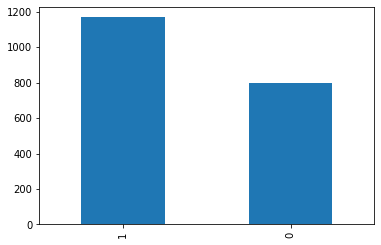

In [13]:
# 若干不均衡データ
学習行列.ラベル.value_counts().plot(kind="bar");

In [14]:
# 特徴量とラベルに分ける
学習X = 学習行列[['テキスト']]
学習y = 学習行列.ラベル
評価X = 評価行列[['テキスト']]
評価y = 評価行列.ラベル

In [15]:
学習X.shape, 評価X.shape

((1970, 1), (843, 1))

In [16]:
def データ前処理(データX:pd.DataFrame=None, データy:np.array=None, テキストコラム名:str='テキスト'):
    ラベル = [{"1": bool(y), "0": not bool(y)} for y in データy]
    テキスト = tuple(データX[テキストコラム名].values.tolist())
    結合データ = list(zip(テキスト, [{"cats": カテゴリー} for カテゴリー in ラベル]))
    
    return 結合データ, テキスト, ラベル

パッディングは最小限に抑える為、バッチごとに系列長の長さに合わせて自動的にグループ分けされます。

In [17]:
# spaCy用にデータを前処理する
学習データ, 学習テキスト, 学習ラベル = データ前処理(学習X, 学習y, "テキスト")
評価データ, 評価テキスト, 評価ラベル = データ前処理(評価X, 評価y, "テキスト")

In [18]:
# 文章分類用のパイプラインを作成する
文書分類パイプ = nlp.create_pipe("trf_textcat", config={"exclusive_classes": True, "architecture": "softmax_class_vector"})
for ラベル in ("1", "0"):
    文書分類パイプ.add_label(ラベル)
nlp.add_pipe(文書分類パイプ, last=True)

In [19]:
# 評価関数
def 文章分類評価(nlp:spacy_transformers.language.TransformersLanguage=None, 
                評価テキスト:tuple=None, 
                評価ラベル:list=None, 
                バッチ数:int=32):
    確率リスト = []
    ラベルリスト = []
    
    for i, 文章 in enumerate(nlp.pipe(評価テキスト, batch_size=バッチ数)):
        予測 = 文章.cats['1']
        ラベル = 1.0 if 評価ラベル[i]['1'] else 0.0
        確率リスト.append(予測)
        ラベルリスト.append(ラベル)
    
    予測インデックス = np.round(確率リスト)
    正解率 = accuracy_score(ラベルリスト, 予測インデックス)
    roc_auc = roc_auc_score(ラベルリスト, 確率リスト)
    f値 = f1_score(ラベルリスト, 予測インデックス)
    適合率 = precision_score(ラベルリスト, 予測インデックス)
    再現率 = recall_score(ラベルリスト, 予測インデックス)
    
    return {'正解率': 正解率, 'roc_auc': roc_auc, 'f値': f値, '適合率': 適合率, '再現率': 再現率}

In [20]:
# Optimizer (Adam)
最適化法 = nlp.resume_training()
最適化法.alpha = 0.001
最適化法.trf_weight_decay = 0.005
最適化法.L2 = 0.0

In [23]:
def 文章分類学習(エポック数:int=5,
               学習データ:list=None,
               評価テキスト:tuple=None,
               評価ラベル:list=None, 
               バッチ数:int=32, 
               学習率:float=1e-3):
    学習状況 = []
    ドロップアウト = decaying(0.2, 0.1, 0.3) # ドロップアウトを0.2から0.1に徐々に減少させる
    # Cyclic triangular rate (https://arxiv.org/abs/1506.01186)
    上昇下降学習率 = cyclic_triangular_rate(
        学習率 / 3, 学習率 * 3, 2 * len(学習データ) // バッチ数
    )

    for エポック in range(エポック数):
        random.shuffle(学習データ)
        全バッチ = minibatch(学習データ, size=バッチ数)
        損失 = {}

        for バッチ in 全バッチ:
            最適化法.trf_lr = next(上昇下降学習率)
            テキスト, ラベル = zip(*バッチ)
            nlp.update(
                テキスト, 
                ラベル, 
                drop = next(ドロップアウト),
                sgd = 最適化法,
                losses=損失)

        print(f"エポック: {エポック+1}")
        print(f"損失: {損失}")
        
        with nlp.use_params(最適化法.averages):
            評価スコア = 文章分類評価(nlp, 評価テキスト, 評価ラベル, バッチ数)

        print(評価スコア)

        学習状況.append(損失)
        学習状況.append(評価スコア)

In [21]:
文章分類学習(エポック数=20, 学習データ=学習データ, 評価テキスト=評価テキスト, 評価ラベル=評価ラベル, バッチ数=32, 学習率=1e-6)

エポック: 1
損失: {'trf_textcat': 0.028460620407713577}
{'正解率': 0.6725978647686833, 'roc_auc': 0.7293191394987801, 'f値': 0.757469244288225, '適合率': 0.6766091051805337, '再現率': 0.8602794411177644}
エポック: 2
損失: {'trf_textcat': 0.025759468393516727}
{'正解率': 0.66429418742586, 'roc_auc': 0.7694085513184158, 'f値': 0.7704785077047851, '適合率': 0.6489071038251366, '再現率': 0.9481037924151696}
エポック: 3
損失: {'trf_textcat': 0.024284954386530444}
{'正解率': 0.7093712930011863, 'roc_auc': 0.7808359888410314, 'f値': 0.7886108714408975, '適合率': 0.6945288753799392, '再現率': 0.9121756487025948}
エポック: 4
損失: {'trf_textcat': 0.022368382633430883}
{'正解率': 0.741399762752076, 'roc_auc': 0.7884231536926147, 'f値': 0.8114186851211073, '適合率': 0.716030534351145, '再現率': 0.936127744510978}
エポック: 5
損失: {'trf_textcat': 0.021247176511678845}
{'正解率': 0.7568208778173191, 'roc_auc': 0.8059436682191172, 'f値': 0.8184233835252435, '適合率': 0.7356687898089171, '再現率': 0.9221556886227545}
エポック: 6
損失: {'trf_textcat': 0.019620090431999415}
{'正解率': 0.7

In [22]:
# 評価
文章分類評価(nlp, 評価テキスト, 評価ラベル, 32)

{'正解率': 0.8078291814946619,
 'roc_auc': 0.8823230731519418,
 'f値': 0.8451242829827916,
 '適合率': 0.8110091743119267,
 '再現率': 0.8822355289421158}

In [23]:
# 重みを平均する (https://www.aclweb.org/anthology/P04-1015/)
with nlp.use_params(最適化法.averages):
    nlp.to_disk('model/ja_bert_textcat_wa')
    
nlp_wa = nlp.from_disk('model/ja_bert_textcat_wa')

In [25]:
# 評価
文章分類評価(nlp_wa, 評価テキスト, 評価ラベル, 32)

{'正解率': 0.8030842230130486,
 'roc_auc': 0.8768836595814219,
 'f値': 0.8442776735459662,
 '適合率': 0.7964601769911505,
 '再現率': 0.8982035928143712}

In [26]:
# 予測関数
def 予測(nlp:spacy_transformers.language.TransformersLanguage=None, 
       評価テキスト:tuple=None, 
       バッチ数:int=32):
    
    確率リスト = []
    
    for i, 文章 in enumerate(nlp.pipe(評価テキスト, batch_size=バッチ数)):
        予測 = 文章.cats['1']
        確率リスト.append(予測)
    
    return 確率リスト

In [29]:
確率 = 予測(nlp, 評価テキスト)
予測インデックス = np.round(確率)

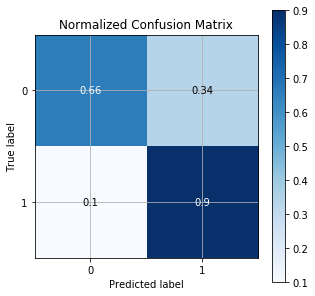

In [30]:
skplt.plot_confusion_matrix(評価y, 予測インデックス, figsize=(5,5), normalize=True);

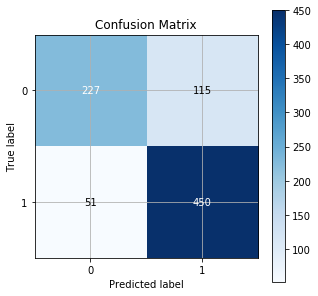

In [31]:
skplt.plot_confusion_matrix(評価y, 予測インデックス, figsize=(5,5), normalize=False);

In [32]:
# 最適な適合率、再現率、f値を計算する
def 適合再現f1計算(評価y:np.ndarray=None, 確率:list=None):
    閾値リスト = []
    閾値 = []
    for 閾 in np.arange(0.01, 1.0, 0.01):
        閾 = np.round(閾, 2)
        再現率 = recall_score(評価y, (確率 > 閾).astype(int))
        適合率 = precision_score(評価y, (確率 > 閾).astype(int))
        f値 = f1_score(評価y, (確率 > 閾).astype(int))
        閾値リスト.append([閾, 再現率, 適合率, f値])
        閾値.append([閾, 再現率, 適合率, f値])

    # f値で並び替え（降順）
    閾値.sort(key=lambda x: x[3], reverse=True)
    最高閾値 = 閾値[0][0]
    最高再現率 = 閾値[0][1]
    最高適合率 = 閾値[0][2]
    最高f値 = 閾値[0][3]
    return  閾値リスト, 最高再現率, 最高適合率, 最高f値, 最高閾値

In [33]:
閾値リスト, 最高再現率, 最高適合率, 最高f値, 最高閾値 = 適合再現f1計算(評価y, 確率)
print(f'最適再現率: {最高再現率} 最適適合率: {最高適合率} 最適f値: {最高f値} 閾値: {最高閾値}')

最適再現率: 0.8642714570858283 最適適合率: 0.8359073359073359 最適f値: 0.8498527968596663 閾値: 0.61


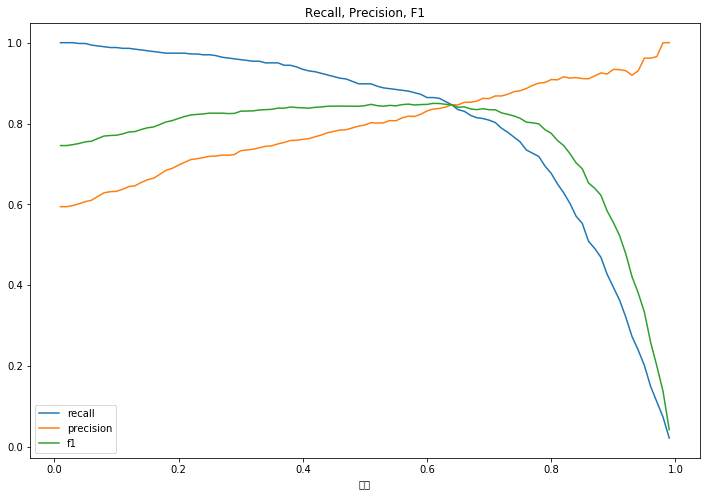

In [35]:
閾値リスト = np.array(閾値リスト)
閾値 = 閾値リスト[:,0]
再現率リスト = 閾値リスト[:,1]
適合率リスト = 閾値リスト[:,2]
f値リスト = 閾値リスト[:,3]

plt.figure(figsize = (12, 8))
plt.plot(閾値, 再現率リスト, label='recall')
plt.plot(閾値, 適合率リスト, label='precision')
plt.plot(閾値, f値リスト, label='f1')
plt.title('Recall, Precision, F1')
plt.xlabel('閾値')
plt.legend()
plt.show();

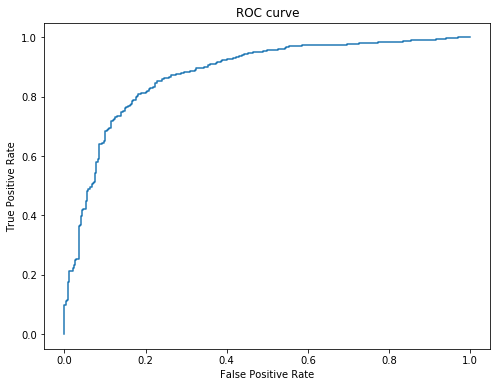

In [36]:
# ROC曲線
fp, tp, thresholds = roc_curve(評価y, 確率)

plt.figure(figsize = (8, 6))
plt.plot(fp, tp)
plt.title("ROC curve")
plt.xlabel( "False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show();

In [37]:
# 予測と正解ラベルの分布比較
評価行列 = pd.DataFrame(予測インデックス, columns=['予測'])
評価行列['確率'] = 確率

ラベルリスト = []

for i in 評価ラベル:
    ラベル = 1.0 if i['1'] else 0.0
    ラベルリスト.append(ラベル)
    
評価行列['ラベル'] = ラベルリスト

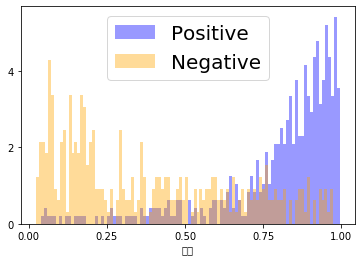

In [38]:
sns.distplot(評価行列[評価行列.ラベル == 1].確率, kde=False, bins=100, color='blue', label='Positive', norm_hist=True)
sns.distplot(評価行列[評価行列.ラベル == 0].確率, kde=False, bins=100, color='orange', label='Negative', norm_hist=True)

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 10
plt.legend();

## Prodigyでのアノテーション　　
[Prodigy](https://prodi.gy/)はウェブ上で動くアノテーションツールでユーザー自身がタグ付けします。アクティブラーニングによりモデルが自信のないデータをユーザーにタグ付けさせます。アノテーションの方法やインターフェースはレシピと呼ばれるもので定義され、標準で文章分類、固有表現抽出、 画像認識、そして物体検出のレシピを搭載しています。自作レシピも可能です。　　

***このツールはオープンソースではありませんのでライセンスが必要になります。オープンソースのツールでは [doccano](https://github.com/doccano/doccano)がおすすめです。

In [33]:
行列 = pd.read_csv('data/train.tsv.bz2', sep='\t', compression='bz2', names=['テキスト', 'ラベル'])
行列.shape

(1970, 2)

In [16]:
# アノテーション用にテキストだけcsvで保存する
行列.テキスト.to_csv("data/test_prodigy.csv", header=False, index=False)

### Prodigyの起動　　
1. ウェブアプリを起動します。
2. ブラウザで`localhost:8888`に接続します。　　

### Prodigyでのアノテーション　　
1. 学習済みモデルを選び、手動でアノテーションします(1000個ほど):  
`prodigy my_set ner.teach en_core_web_lg data/test_prodigy.csv`  
2. モデルを学習します:  
`prodigy train ner my_set en_core_web_lg --output model/ner_v1 --n-iter 5 --eval-split 0.2 --dropout 0.2`  
3.  `ner.correct`と`train`を精度が上がるまで交互に実行します:  
`prodigy ner.correct my_set model/ner_v1 data/test_prodigy.csv`  
`prodigy train ner my_set en_core_web_lg --output model/ner_v2 --n-iter 5 --eval-split 0.2 --dropout 0.2`  
`prodigy ner.correct my_set model/ner_v2 data/test_prodigy.csv`  
...
4. 完了です。学習されたモデルはspaCy使用できます。
5. 更にラベル付けされたデータをJSONLファイルに出力する事も可能です:
`prodigy ner.gold-to-spacy my_set data/ner_gold.jsonl --biluo --spacy-model model/ner_v8`
6. 出力されたデータを他のフレームワークと使って学習する事もできます。例えば、AllenNLP用に変換するには下記を参照してください。

In [ ]:
import json

with open('data/ner_gold.jsonl') as jsonファイル:
    prodigyゴールド = [json.loads(ライン) for ライン in jsonファイル]
    
nerリスト = []
for 行 in prodigyゴールド:
    テキスト = 行[0]
    ラベル = 行[1]
    
    連結テキスト = ""
    カウンタ = 0
    
    for テキスト in テキスト.split(" "):
        ラベル付きテキスト = テキスト + "#" + ラベル[カウンタ]
        連結テキスト = 連結テキスト + ラベル付きテキスト + " "
        カウンタ += 1

    nerリスト.append(連結テキスト.strip())

ner行列 = pd.DataFrame(nerリスト, columns=['テキスト'])

In [ ]:
# 学習データと評価データに分ける
学習X, 評価X = train_test_split(ner行列, test_size=0.2, random_state=1)

In [ ]:
# データを保存する
学習X.to_csv("data/ner_train_allennlp.csv.bz2", compression='bz2', header=False, index=False)
評価X.to_csv("data/ner_val_allennlp.csv.bz2", compression='bz2', header=False, index=False)